The CRO claimed win rate has dropped over the last two quarters but pipeline volume looks healthy. In other words, the company is still generating opportunities, but fewer of those opportunities are converting into wins.

We start by loading the data just to confirm the dataset shape (rows/columns) and inspect a few example rows to understand what each field represents, also checking for missing values and inconsistent category labels.

In [124]:
import numpy as np
import pandas as pd

df = pd.read_csv("skygeni_sales_data.csv")

print(df.shape)
print(df.head())

#check for missing values 
df.columns
df.isna().sum().sort_values(ascending=False)

(5000, 12)
  deal_id created_date closed_date sales_rep_id    industry         region  \
0  D00001   2023-11-24  2023-12-15       rep_22        SaaS  North America   
1  D00002   2023-01-17  2023-01-27        rep_7        SaaS          India   
2  D00003   2023-10-29  2023-12-10        rep_5  HealthTech           APAC   
3  D00004   2023-07-14  2023-08-02       rep_18     FinTech          India   
4  D00005   2024-02-29  2024-05-26        rep_2  HealthTech           APAC   

  product_type lead_source   deal_stage  deal_amount  sales_cycle_days outcome  
0   Enterprise    Referral    Qualified         4253                21     Won  
1         Core    Referral       Closed         3905                10     Won  
2         Core     Inbound     Proposal        10615                42    Lost  
3         Core     Partner  Negotiation         4817                19     Won  
4         Core    Outbound    Qualified        45203                87    Lost  


deal_id             0
created_date        0
closed_date         0
sales_rep_id        0
industry            0
region              0
product_type        0
lead_source         0
deal_stage          0
deal_amount         0
sales_cycle_days    0
outcome             0
dtype: int64

In [125]:
#covert dates to standard format == datetime objects
df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")
df["closed_date"] = pd.to_datetime(df["closed_date"], errors="coerce")

#df[["created_date", "closed_date"]].head()

In [126]:
#Quantifying/checking the totals
# outcome values
df["outcome"].value_counts(dropna=False)

# deal stages
#df["deal_stage"].value_counts(dropna=False).head()

# deal_amount
#df["deal_amount"].describe()

outcome
Lost    2737
Won     2263
Name: count, dtype: int64

In [127]:
#key columns to analyse sales cycle, win rate/pipeline vol per quarter etc,.

#deal duration is basically the sales cycle length
df["deal_duration_days"] = (df["closed_date"] - df["created_date"]).dt.days
df["created_quarter"] = df["created_date"].dt.to_period("Q").astype(str)
df["closed_quarter"] = df["closed_date"].dt.to_period("Q").astype(str)
df[["deal_id", "created_date", "closed_date", "deal_duration_days", "created_quarter", "closed_quarter", "outcome"]].head(10)

,deal_id,created_date,closed_date,deal_duration_days,created_quarter,closed_quarter,outcome
0,D00001,2023-11-24,2023-12-15,21,2023Q4,2023Q4,Won
1,D00002,2023-01-17,2023-01-27,10,2023Q1,2023Q1,Won
2,D00003,2023-10-29,2023-12-10,42,2023Q4,2023Q4,Lost
3,D00004,2023-07-14,2023-08-02,19,2023Q3,2023Q3,Won
4,D00005,2024-02-29,2024-05-26,87,2024Q1,2024Q2,Lost
5,D00006,2024-03-19,2024-04-07,19,2024Q1,2024Q2,Won
6,D00007,2023-11-08,2024-02-04,88,2023Q4,2024Q1,Won
7,D00008,2024-03-07,2024-06-20,105,2024Q1,2024Q2,Lost
8,D00009,2023-07-22,2023-11-19,120,2023Q3,2023Q4,Lost
9,D00010,2023-10-26,2023-12-23,58,2023Q4,2023Q4,Won


Win rate only makes sense for deals that have reached an outcome. Therefore, when computing win rate we filter the dataset to deals where outcome is either Won or Lost (and closed_date is present) i.e, open deals are excluded

In [128]:
#Subset of closed deals
closed_df = df[df["outcome"].isin(["Won", "Lost"])].copy()

print("Closed deals:", closed_df.shape[0])
closed_df["outcome"].value_counts()

Closed deals: 5000


outcome
Lost    2737
Won     2263
Name: count, dtype: int64

Win rate is the fraction of closed deals that were won. It is calculated as:

$$\text{Win Rate} = \frac{\# \text{Won}}{\# \text{Won} + \# \text{Lost}}$$

It summarizes how efficiently the sales team converts pipeline into revenue. However, win rate can change because of various factors like the sales team performance, changes in industried/lead sources/regions, or because the market environment changes.

Additonally, win rate is computed by closed_quarter (rather than created_quarter) because the CRO’s complaint is about conversion outcomes. A deal created in Q1 might close in Q2, so grouping by closed_quarter captures when wins/losses actually happened.

In [129]:
#win rate per Q == wins/wins + loses
win_rate_by_q = (
    closed_df
    .groupby("closed_quarter")["outcome"]
    .apply(lambda x: (x == "Won").mean())
    .sort_index()
)

win_rate_by_q

closed_quarter
2023Q1    0.445122
2023Q2    0.450154
2023Q3    0.428150
2023Q4    0.475170
2024Q1    0.466667
2024Q2    0.437991
2024Q3    0.517241
Name: outcome, dtype: float64

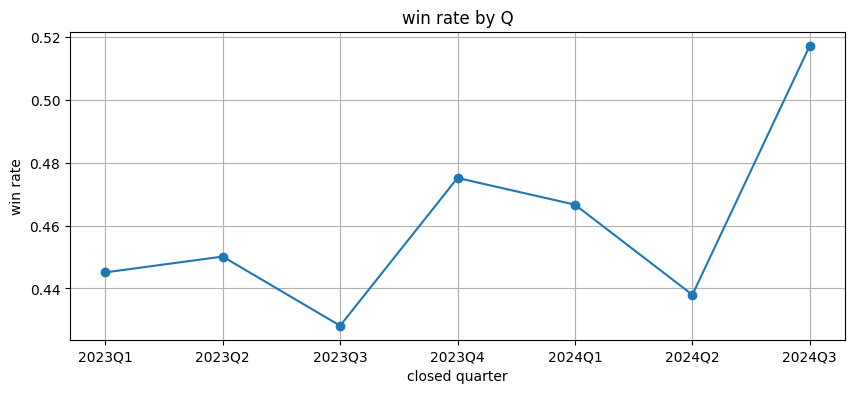

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
win_rate_by_q.plot(marker="o")
plt.title("win rate by Q")
plt.ylabel("win rate")
plt.xlabel("closed quarter")
plt.grid(True)
plt.show()


--------------
Pipeline volume is approximated using deals created per quarter and total deal amount created per quarter. This measures pipeline inflow so how many new opportunities are entering the funnel. If this volume is stable but win rate drops, it would mean the problem is downstream (conversion quality, execution, or market conditions) rather than top-of-funnel volume.

In [131]:
#pipeline volume per created Q

deals_created_by_q = df.groupby("created_quarter")["deal_id"].count().sort_index()
deals_created_by_q

created_quarter
2023Q1    1006
2023Q2    1014
2023Q3    1006
2023Q4    1013
2024Q1     961
Name: deal_id, dtype: int64

In [132]:
amount_created_by_q = df.groupby("created_quarter")["deal_amount"].sum().sort_index()
amount_created_by_q

created_quarter
2023Q1    25286077
2023Q2    27115555
2023Q3    26375100
2023Q4    26977557
2024Q1    25678175
Name: deal_amount, dtype: int64

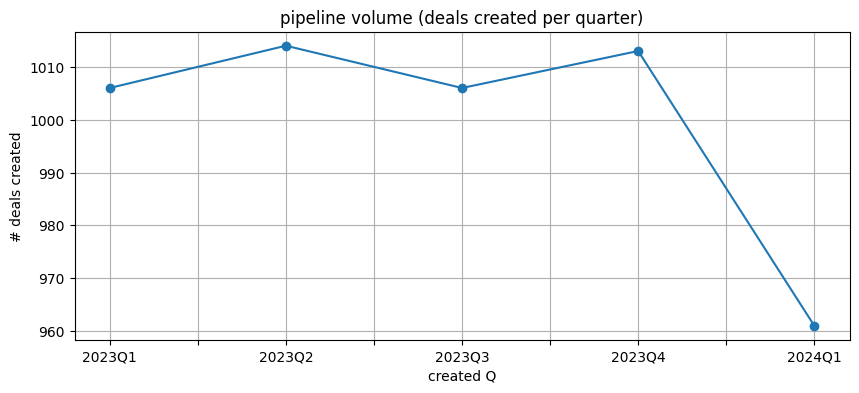

In [133]:
plt.figure(figsize=(10,4))
deals_created_by_q.plot(marker="o")
plt.title("pipeline volume (deals created per quarter)")
plt.ylabel("# deals created")
plt.xlabel("created Q")
plt.grid(True)
plt.show()

The first step is to check whether the CRO’s statement is supported by the data. When computed by closed quarter, win rate dips in 2024Q2 compared to 2024Q1. At the same time, the number of deals created per quarter remains relatively stable, which supports the CRO’s belief that pipeline inflow is healthy. This suggests the problem is not “not enough opportunities,” but rather reduced conversion and/or slower deal execution.

------------
Now that we have an idea of the original problem statement and the data confirming that problem, we can compute win rate per Q according to category so we know what actually is the issue (if anything). To speed up analysis and keep the notebook consistent, \a helper function (win_rate_table) is created that computes deal count, wins, losses, win rate, average deal amount, and median deal duration for any grouping.

In [134]:
#create a function to compute win rate wrt category

def win_rate_table(df, group_cols):
    """
    returns a table with:
    - deals
    - wins
    - losses
    - win_rate
    """
    output = (
        df
        .groupby(group_cols)
        .agg(
            deals=("deal_id", "count"),
            wins=("outcome", lambda x: (x == "Won").sum()),
            losses=("outcome", lambda x: (x == "Lost").sum()),
            win_rate=("outcome", lambda x: (x == "Won").mean()),
            avg_amount=("deal_amount", "mean"),
            median_duration=("deal_duration_days", "median"),
        )
        .reset_index()
    )
    return output

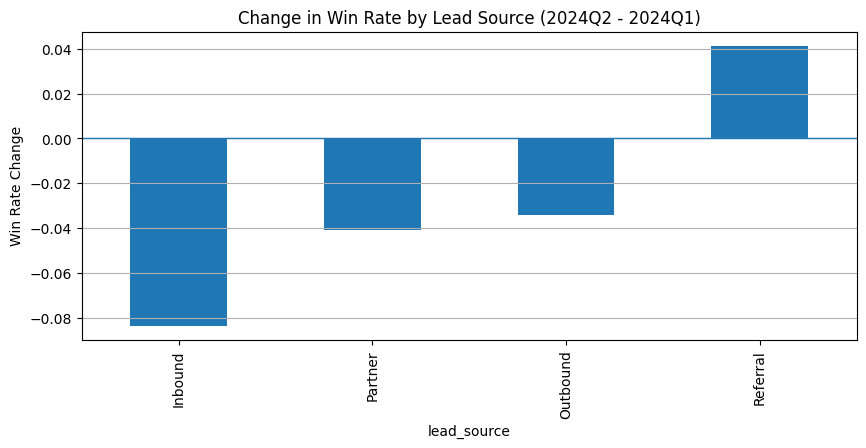

In [135]:
#weaker leads
#win rate by lead source

lead_source_wr = win_rate_table(closed_df, ["closed_quarter", "lead_source"])
lead_source_wr.sort_values(["closed_quarter", "win_rate"]).head(20)

qtrs = ["2024Q1", "2024Q2"]
tmp_source = lead_source_wr[lead_source_wr["closed_quarter"].isin(qtrs)].copy()

pivot_source = tmp_source.pivot(index="lead_source", columns="closed_quarter", values="win_rate")
pivot_source = pivot_source.sort_values("2024Q2")

delta_source = (pivot_source["2024Q2"] - pivot_source["2024Q1"]).sort_values()

plt.figure(figsize=(10,4))
delta_source.plot(kind="bar")
plt.axhline(0, linewidth=1)
plt.title("Change in Win Rate by Lead Source (2024Q2 - 2024Q1)")
plt.ylabel("Win Rate Change")
plt.grid(True, axis="y")
plt.show()

In [136]:
'''
We look at how the deals in the inbound lead source pipeline fared over the last 3 quarters 
-- win rate
-- revenue
-- cycle duration

'''

focus_inbound = closed_df[
    (closed_df["lead_source"] == "Inbound") &
    (closed_df["closed_quarter"].isin(["2024Q1", "2024Q2", "2024Q3"]))
].copy()

focus_inbound.groupby("closed_quarter").agg(
    deals=("deal_id", "count"),
    win_rate=("outcome", lambda x: (x == "Won").mean()),
    avg_amount=("deal_amount", "mean"),
    median_duration=("deal_duration_days", "median"),
)

,deals,win_rate,avg_amount,median_duration
closed_quarter,,,,
2024Q1,254,0.488189,26499.913386,63.5
2024Q2,168,0.404762,26748.678571,87.5
2024Q3,8,0.375000,25866.750000,109.0


In [137]:
'''
look at the share of deals + win rate in each category of the lead sourcing 
'''

tmp_source["share"] = tmp_source.groupby("closed_quarter")["deals"].transform(lambda x: x / x.sum())

tmp_source[["closed_quarter", "lead_source", "deals", "share", "win_rate"]].sort_values(
    ["closed_quarter", "share"], ascending=[True, False]
)

,closed_quarter,lead_source,deals,share,win_rate
17,2024Q1,Outbound,260,0.262626,0.453846
16,2024Q1,Inbound,254,0.256566,0.488189
19,2024Q1,Referral,241,0.243434,0.464730
18,2024Q1,Partner,235,0.237374,0.459574
21,2024Q2,Outbound,174,0.273155,0.419540
20,2024Q2,Inbound,168,0.263736,0.404762
23,2024Q2,Referral,166,0.260597,0.506024
22,2024Q2,Partner,129,0.202512,0.418605


In [138]:
duration_tbl = (
    closed_df[closed_df["closed_quarter"].isin(["2024Q1", "2024Q2"])]
    .groupby(["closed_quarter", "lead_source"])["deal_duration_days"]
    .median()
    .reset_index()
)

duration_pivot = duration_tbl.pivot(index="lead_source", columns="closed_quarter", values="deal_duration_days")
duration_pivot

closed_quarter,2024Q1,2024Q2
lead_source,,
Inbound,63.5,87.5
Outbound,67.0,82.5
Partner,61.0,86.0
Referral,62.0,88.5


Inbound deals show the largest win-rate decline from 2024Q1 to 2024Q2, and inbound deal durations increase substantially. Inbound win rate drops from roughly 48.8% to 40.5%, and median deal duration increases from about 63.5 days to 87.5 days. Because inbound deal volume is large in both quarters, this change is unlikely to be explained by small sample randomness. This might suggest that inbound opportunities in Q2 are both slower and less likely to convert, which is consistent with less leads qualifying, lower intent inbound traffic, or a slowdown in customer decision-making.

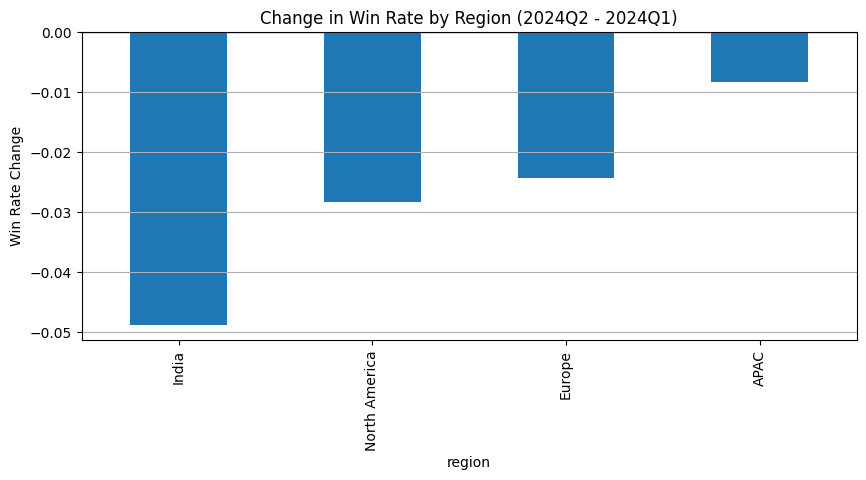

In [139]:
region_wr = win_rate_table(closed_df, ["closed_quarter", "region"])
region_wr.sort_values(["closed_quarter", "win_rate"]).head(20)

qtrs = ["2024Q1", "2024Q2"]
tmp_region = region_wr[region_wr["closed_quarter"].isin(qtrs)].copy()

pivot_region = tmp_region.pivot(index="region", columns="closed_quarter", values="win_rate")
pivot_region = pivot_region.sort_values("2024Q2")

delta_region = (pivot_region["2024Q2"] - pivot_region["2024Q1"]).sort_values()

plt.figure(figsize=(10,4))
delta_region.plot(kind="bar")
plt.axhline(0, linewidth=1)
plt.title("Change in Win Rate by Region (2024Q2 - 2024Q1)")
plt.ylabel("Win Rate Change")
plt.grid(True, axis="y")
plt.show()

Region is a super common driver in B2B sales because different regions behave differently due to economic conditions, local competition etc,. Region specific winrates were checked. While they did change, I focused more on lead source, industry, and deal velocity which showed stronger signals.

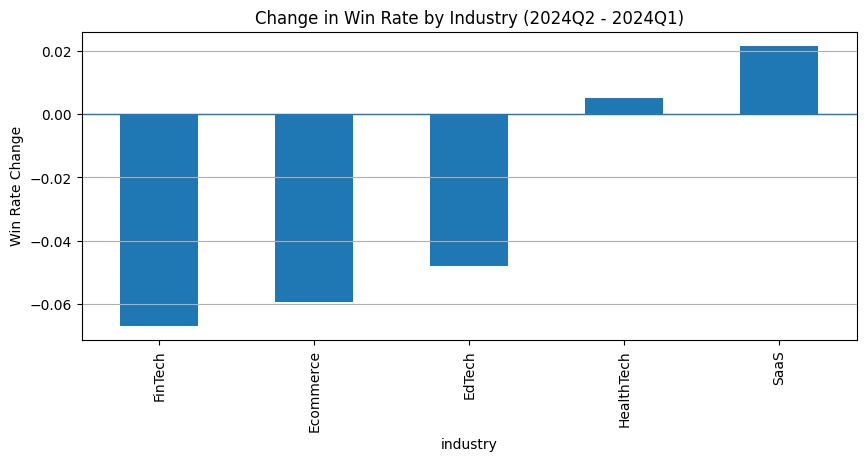

In [140]:
industry_wr = win_rate_table(closed_df, ["closed_quarter", "industry"])
industry_wr.sort_values(["closed_quarter", "win_rate"]).head(20)

qtrs = ["2024Q1", "2024Q2", "2024Q3"]
tmp_industry = industry_wr[industry_wr["closed_quarter"].isin(qtrs)].copy()

pivot_industry = tmp_industry.pivot(index="industry", columns="closed_quarter", values="win_rate")
pivot_industry = pivot_industry.sort_values("2024Q2")

delta_industry = (pivot_industry["2024Q2"] - pivot_industry["2024Q1"]).sort_values()
#delta_industry_2 = (pivot_industry["2024Q3"] - pivot_industry["2024Q2"]).sort_values()

plt.figure(figsize=(10,4))
delta_industry.plot(kind="bar")
plt.axhline(0, linewidth=1)
plt.title("Change in Win Rate by Industry (2024Q2 - 2024Q1)")
plt.ylabel("Win Rate Change")
plt.grid(True, axis="y")
plt.show()

In [141]:
industry_wr = win_rate_table(closed_df, ["closed_quarter", "industry"])

qtrs = ["2024Q1", "2024Q2"]
tmp_industry = industry_wr[industry_wr["closed_quarter"].isin(qtrs)].copy()

tmp_industry["share"] = tmp_industry.groupby("closed_quarter")["deals"].transform(lambda x: x / x.sum())

tmp_industry.sort_values(["closed_quarter", "share"], ascending=[True, False])[
    ["closed_quarter", "industry", "deals", "share", "win_rate", "median_duration"]
]

,closed_quarter,industry,deals,share,win_rate,median_duration
20,2024Q1,Ecommerce,207,0.209091,0.478261,63.0
21,2024Q1,EdTech,203,0.205051,0.443350,65.0
23,2024Q1,HealthTech,195,0.196970,0.456410,64.0
24,2024Q1,SaaS,194,0.195960,0.448454,60.5
22,2024Q1,FinTech,191,0.192929,0.507853,61.0
29,2024Q2,SaaS,134,0.210361,0.470149,83.5
28,2024Q2,HealthTech,130,0.204082,0.461538,88.0
26,2024Q2,EdTech,129,0.202512,0.395349,90.0
27,2024Q2,FinTech,127,0.199372,0.440945,85.0
25,2024Q2,Ecommerce,117,0.183673,0.418803,82.0


In [142]:
focus = closed_df[
    (closed_df["industry"] == "FinTech") &
    (closed_df["closed_quarter"].isin(["2024Q1", "2024Q2", "2024Q3"]))
].copy()

focus.groupby("closed_quarter").agg(
    deals=("deal_id", "count"),
    win_rate=("outcome", lambda x: (x == "Won").mean()),
    avg_amount=("deal_amount", "mean"),
    median_duration=("deal_duration_days", "median"),
)

,deals,win_rate,avg_amount,median_duration
closed_quarter,,,,
2024Q1,191,0.507853,28282.664921,61.0
2024Q2,127,0.440945,26060.330709,85.0
2024Q3,4,0.250000,29503.000000,111.0


Industry-level breakdown shows that the win-rate decline is not evenly distributed across all industries. FinTech in particular shows a meaningful drop with large deal volume: win rate declines from approximately 50.8% (191 deals) in 2024Q1 to approximately 44.1% (127 deals) in 2024Q2, and median deal duration increases from 61 to 85 days. The sample size is pretty large for both Q's so unlikely to be noise.

We also checked whether the Q2 win-rate decline could be explained by the company doing “more of the wrong kinds of deals”. Looking at industry share of closed deals, the mix is actually pretty stable between 2024Q1 and 2024Q2 -- each industry stays around 18–21% of the quarter. FinTech’s share increases slightly (19.3% to 19.9%), but the bigger story is that FinTech’s win rate drops significantly (50.8% to 44.1%) while the median deal duration jumps (61 to 85 days). So this isn’t mainly a "kind of deals" issue; it’s more that performance inside FinTech (and also EdTech/Ecommerce) got worse in Q2.

In [143]:
#sales rep quality
#win rate by rep/Q

rep_wr = win_rate_table(closed_df, ["closed_quarter", "sales_rep_id"])
rep_q2 = rep_wr[rep_wr["closed_quarter"].isin(["2024Q1", "2024Q2"])].copy()
rep_q2 = rep_q2[rep_q2["deals"] >= 30]  # filter small sample reps

#rep_q2.sort_values("win_rate").head(15)

pivot_rep = rep_q2.pivot(index="sales_rep_id", columns="closed_quarter", values="win_rate")
pivot_rep = pivot_rep.dropna()

pivot_rep["delta"] = pivot_rep["2024Q2"] - pivot_rep["2024Q1"]
pivot_rep = pivot_rep.sort_values("delta")

pivot_rep.head(15)

closed_quarter,2024Q1,2024Q2,delta
sales_rep_id,,,
rep_2,0.543478,0.400000,-0.143478
rep_11,0.459459,0.333333,-0.126126
rep_5,0.538462,0.468750,-0.069712
rep_22,0.405405,0.388889,-0.016517
rep_16,0.509434,0.516129,0.006695
rep_1,0.294118,0.483871,0.189753


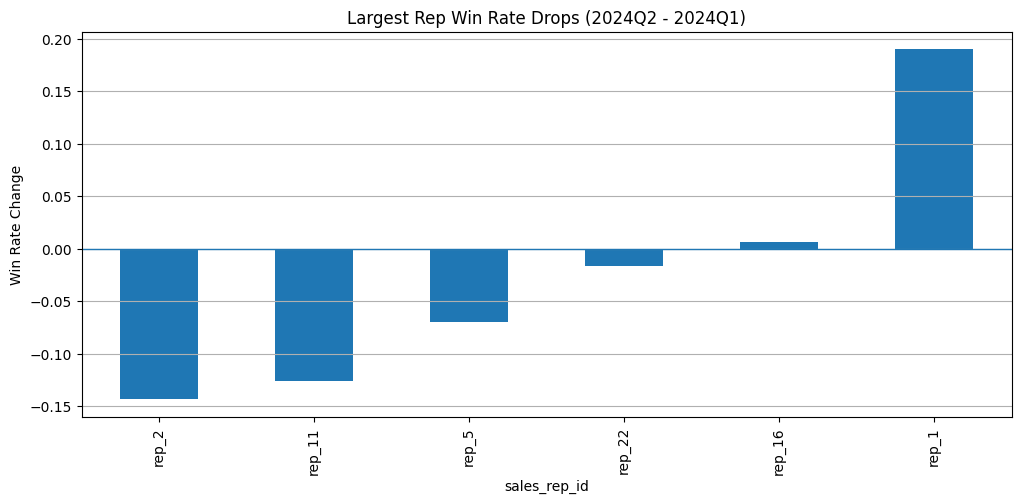

In [144]:
plt.figure(figsize=(12,5))
pivot_rep["delta"].head(15).plot(kind="bar")
plt.axhline(0, linewidth=1)
plt.title("Largest Rep Win Rate Drops (2024Q2 - 2024Q1)")
plt.ylabel("Win Rate Change")
plt.grid(True, axis="y")
plt.show()

In [145]:
rep_detail = (
    closed_df[closed_df["closed_quarter"].isin(["2024Q1", "2024Q2"])]
    .groupby(["closed_quarter", "sales_rep_id"])
    .agg(
        deals=("deal_id", "count"),
        win_rate=("outcome", lambda x: (x == "Won").mean()),
        avg_amount=("deal_amount", "mean"),
        median_duration=("deal_duration_days", "median"),
    )
    .reset_index()
)

rep_detail[rep_detail["sales_rep_id"].isin(pivot_rep.head(5).index)]

,closed_quarter,sales_rep_id,deals,win_rate,avg_amount,median_duration
2,2024Q1,rep_11,37,0.459459,37283.405405,61.0
7,2024Q1,rep_16,53,0.509434,24479.264151,57.0
11,2024Q1,rep_2,46,0.543478,34997.000000,52.0
14,2024Q1,rep_22,37,0.405405,19677.135135,64.0
20,2024Q1,rep_5,39,0.538462,25913.743590,67.0
27,2024Q2,rep_11,39,0.333333,30677.179487,95.0
32,2024Q2,rep_16,31,0.516129,25662.387097,95.0
36,2024Q2,rep_2,30,0.400000,24958.700000,88.5
39,2024Q2,rep_22,36,0.388889,21451.666667,76.5
45,2024Q2,rep_5,32,0.468750,31411.875000,86.5


In addition to segment-level drivers, rep-level breakdown shows that some reps experienced significant declines in win rate between 2024Q1 and 2024Q2. For example, rep_11 declines from approximately 46% to 33% win rate, and rep_2 declines from approximately 54% to 40%. These declines coincide with sharp increases in median deal duration for those reps. However, since the overall company median deal duration also increased substantially in Q2, rep-level declines should be interpreted as part of a broader slowdown rather than an individual problem.

------------------
We also compute the median deal duration (closed_date − created_date). Between 2024Q1 and 2024Q2, median duration increases sharply (63 to 86 days). This might suggest a company-wide slowdown in deal velocity -- in B2B SaaS, longer deal cycles often correlate with lower win rates because deals lose momentum, customers delay decisions, and more deals stall before closing.

In [146]:
overall_duration = (
    closed_df[closed_df["closed_quarter"].isin(["2024Q1", "2024Q2"])]
    .groupby("closed_quarter")["deal_duration_days"]
    .median()
)

overall_duration

closed_quarter
2024Q1    63.0
2024Q2    86.0
Name: deal_duration_days, dtype: float64

-------
-----------------
**CUSTOM METRICS**

**% of deals taking > 90 days?**

One of the most common early warning signs in B2B SaaS sales is deal stalling: when deals remain in the pipeline for an unusually long time before closing. Even if pipeline volume looks healthy, a rising number of stalled deals often indicate weaker momentum which might be seen as a reduction in win rate. To quantify the stalling, we look at the fraction of closed deals whose duration exceeds a fixed threshold (here, 90 days is chosen as most deals are expected to close within one quarter).


*DEAL STALL RATE*

As mentioned above, when deals start taking longer and losing momentum, the pipeline can still look “healthy” because deals are still being created, but fewer deals actually close successfully. 
Deal Stall Rate is meant to capture this, so instead of only looking at whether deals were won or lost, it measures whether the business is accumulating an unusually large number of long-running deals. As mentioned above, threshold is not meant to be a perfect universal cutoff.

$$\text{Deal Stall Rate} = P(\text{deal duration} > 90 \text{days})$$

In a stable sales system, Deal Stall Rate should be relatively consistent quarter to quarter. If the business is healthy, it might fluctuate slightly but should not jump dramatically. If the sales process slows down, the rate typically increases, because more deals get stuck and take longer to resolve.

Please note, the analysis does not assume that every deal over 90 days is guaranteed to lose. The purpose is to measure whether the business is experiencing a shift toward longer-running deals.

In this dataset, the stall rate increases from approximately 25% in 2024Q1 to 43% in 2024Q2, indicating a sharp rise in long-running deals.

In [147]:
temp = closed_df[closed_df["closed_quarter"].isin(["2024Q1","2024Q2"])].copy()
temp["over_90"] = temp["deal_duration_days"] > 90

over_ninety = (
    temp.groupby("closed_quarter")["over_90"]
    .mean()
)

over_ninety

closed_quarter
2024Q1    0.254545
2024Q2    0.430141
Name: over_90, dtype: float64

-------------------
*REVENUE WEIGHTED WIN RATE*

standard win rate treats every deal as equally important. A 5K deal and a 50K deal both contribute equally to the win-rate calculation. In reality, losing one high-value deal can matter more than losing several low-value deals. For this reason, a second custom metric is introduced: Revenue Weighted win rate.
This metric measures conversion in terms of total revenue value rather than deal count. It's computed by summing deal_amount separately for Won and Lost deals in each quarter.

$$\text{Revenue weighed WR} = \frac{\text{Revenue of Won deals}}{\sum{\text{Revenue of Won deals}} + \sum{\text{Revenue of Lost deals}}}$$

If this metric declines sharply, it suggests the company is losing a larger fraction of high-value revenue opportunities. This is a more severe business outcome than simply losing more deals. If standard win rate declines but ACV-weighted win rate remains stable, it suggests the company may be losing more low-value deals while still successfully converting higher-value deals. It is highly useful for prioritization.

In [148]:
temp_rev = closed_df[closed_df["closed_quarter"].isin(["2024Q1","2024Q2"])].copy()

Rev_wr = (
    temp_rev.groupby(["closed_quarter", "outcome"])["deal_amount"]
    .sum()
    .reset_index()
)

Rev_pivot = (
    Rev_wr.pivot(index="closed_quarter", columns="outcome", values="deal_amount")
    .fillna(0)
)

Rev_pivot["Rev_weighted_win_rate"] = Rev_pivot["Won"] / (Rev_pivot["Won"] + Rev_pivot["Lost"])

Rev_pivot

outcome,Lost,Won,Rev_weighted_win_rate
closed_quarter,,,
2024Q1,13711434,12702445,0.480900
2024Q2,9490480,7518918,0.442045


This metric dropped from around 48.1% in 2024Q1 to 44.2% in 2024Q2. This suggests that the Q2 decline is not only a deal-count issue, it also reflects a shift toward losing a larger fraction of revenue value, meaning the drop likely mattered materially to the business.

P.S. the weighted win rate should be interpreted as a proportion, not as a total revenue comparison.

-----------
*CATEGORY-ADJUSTED EXPECTED WIN RATE*

Win rate can decrease for 2 general reasons: first, because the company’s performance worsened within the same types of deals (for example, inbound deals used to convert at 49% but now convert at 41%). Second, even if performance did not change, simply because the mix of deals shifted toward segments that historically win less. This distinction is important because the action taken is either strategic or operational i.e, change targeting or improve execution.

This is a one-dimensional mix adjustment based on lead source; in production this could be extended to a multivariate expected win-rate model and is highly actionable. It estimates what win rate would be expected in Q2 if lead-source performance had stayed the same as Q1, given the lead sources we are closing deals from.

The metric is computed in two steps. First, baseline win rates are computed for each lead source using a baseline quarter (in this case, 2024Q1). This produces a reference win rate for inbound, outbound, partner, and referral. Second, the lead-source mix in the target quarter (2024Q2) is computed as the share of closed deals coming from each lead source. The expected win rate is then computed as a weighted average:

$$\text{Expected} WR_{Q2} = \sum{share_{Q2} + winrate_{Q1}}$$

In [149]:
# baseline win rate per lead_source from Q1
base = lead_source_wr[lead_source_wr["closed_quarter"]=="2024Q1"].set_index("lead_source")["win_rate"]

# Q2 lead_source shares
q2 = lead_source_wr[lead_source_wr["closed_quarter"]=="2024Q2"].copy()
q2["share"] = q2["deals"] / q2["deals"].sum()

# expected Q2 win rate if lead_source performance stayed like Q1
expected_q2_wr = (q2["share"] * q2["lead_source"].map(base)).sum()

# actual Q2 win rate
actual_q2_wr = (q2["share"] * q2["win_rate"]).sum()

expected_q2_wr, actual_q2_wr, actual_q2_wr - expected_q2_wr

(0.4669000210352798, 0.4379905808477237, -0.02890944018755609)

Even if Q2 had the exact same lead-source performance as Q1, the mix of lead sources would predict a Q2 win rate of ~46.7%. 
But the real Q2 win rate is only ~43.8%.

So about 2.9 percentage points of the drop can explained by lead sources performing worse.

------------
------------

**DECISION ENGINE**

*WIN RATE DRIVER ANALYSIS*

This decision engine is made to convert the exploratory analysis we did prior into a repeatable system that can answer the question: “What should the sales team focus on right now to improve outcomes?” 
The engine decomposes the win-rate change into segment-level drivers (lead source, industry, and sales rep).

The engine ranks segments not only by how much their win rate changed, but by how important they are to the business. This is necessary because a segment with a large win-rate drop might still have little impact if it represents only a small number of deals.

The engine computes an impact score for each segment defined as the segment’s win-rate change multiplied by its share of closed deals in Q2. This produces a prioritized list of drivers that are both 
-- performing worse 
-- large enough to materially influence overall performance. 

For each segment (lead source, industry, sales rep), the engine computes:

* win rate in 2024Q1
* win rate in 2024Q2
* change in win rate (Q2 − Q1)
* share of closed deals in 2024Q2
* impact score, defined as:

$$\text{Impact} = \text{(win rate Q2 - win rate Q1)} \times \text{(Q2 share)}$$

The engine also reports changes in median deal duration for each segment to identify whether declining performance coincides with slower deal velocity, which was a major pattern observed in Q2.

In [150]:
#Lead source drivers

q1 = lead_source_wr[lead_source_wr["closed_quarter"]=="2024Q1"][["lead_source","deals","win_rate"]]
q2 = lead_source_wr[lead_source_wr["closed_quarter"]=="2024Q2"][["lead_source","deals","win_rate"]]

lead_drivers = q1.merge(q2, on="lead_source", suffixes=("_q1","_q2"))
lead_drivers["q2_share"] = lead_drivers["deals_q2"] / lead_drivers["deals_q2"].sum()
lead_drivers["delta_win_rate"] = lead_drivers["win_rate_q2"] - lead_drivers["win_rate_q1"]
lead_drivers["impact"] = lead_drivers["delta_win_rate"] * lead_drivers["q2_share"]

lead_drivers.sort_values("impact")

,lead_source,deals_q1,win_rate_q1,deals_q2,win_rate_q2,q2_share,delta_win_rate,impact
0,Inbound,254,0.488189,168,0.404762,0.263736,-0.083427,-0.022003
1,Outbound,260,0.453846,174,0.419540,0.273155,-0.034306,-0.009371
2,Partner,235,0.459574,129,0.418605,0.202512,-0.040970,-0.008297
3,Referral,241,0.464730,166,0.506024,0.260597,0.041294,0.010761


Inbound is a huge portion of deals, and it got substantially worse. Outbound and partner also decline, but with smaller impact. Referral improves significantly, meaning not all channels degraded in Q2.

In [151]:
#Industry drivers

industry_wr = win_rate_table(closed_df, ["closed_quarter","industry"])

q1 = industry_wr[industry_wr["closed_quarter"]=="2024Q1"][["industry","deals","win_rate"]]
q2 = industry_wr[industry_wr["closed_quarter"]=="2024Q2"][["industry","deals","win_rate"]]

industry_drivers = q1.merge(q2, on="industry", suffixes=("_q1","_q2"))
industry_drivers["q2_share"] = industry_drivers["deals_q2"] / industry_drivers["deals_q2"].sum()
industry_drivers["delta_win_rate"] = industry_drivers["win_rate_q2"] - industry_drivers["win_rate_q1"]
industry_drivers["impact"] = industry_drivers["delta_win_rate"] * industry_drivers["q2_share"]

industry_drivers.sort_values("impact")

,industry,deals_q1,win_rate_q1,deals_q2,win_rate_q2,q2_share,delta_win_rate,impact
2,FinTech,191,0.507853,127,0.440945,0.199372,-0.066909,-0.013340
0,Ecommerce,207,0.478261,117,0.418803,0.183673,-0.059457,-0.010921
1,EdTech,203,0.443350,129,0.395349,0.202512,-0.048001,-0.009721
3,HealthTech,195,0.456410,130,0.461538,0.204082,0.005128,0.001047
4,SaaS,194,0.448454,134,0.470149,0.210361,0.021696,0.004564


Industry analysis shows that the Q2 decline is concentrated in specific industries. FinTech has the largest negative impact, driven by a meaningful win-rate drop and high deal share (~20%). Ecommerce and EdTech also show significant negative impact. Meanwhile, SaaS and HealthTech are stable or improving.

In [157]:
#Rep drivers

rep_wr = win_rate_table(closed_df, ["closed_quarter","sales_rep_id"])

q1 = rep_wr[rep_wr["closed_quarter"]=="2024Q1"][["sales_rep_id","deals","win_rate"]]
q2 = rep_wr[rep_wr["closed_quarter"]=="2024Q2"][["sales_rep_id","deals","win_rate"]]

rep_drivers = q1.merge(q2, on="sales_rep_id", suffixes=("_q1","_q2"))
rep_drivers = rep_drivers[rep_drivers["deals_q2"] >= 30]  # avoid noise
rep_drivers["q2_share"] = rep_drivers["deals_q2"] / rep_wr[rep_wr["closed_quarter"]=="2024Q2"]["deals"].sum()
rep_drivers["delta_win_rate"] = rep_drivers["win_rate_q2"] - rep_drivers["win_rate_q1"]
rep_drivers["impact"] = rep_drivers["delta_win_rate"] * rep_drivers["q2_share"]

rep_drivers.sort_values("impact").head(10)

,sales_rep_id,deals_q1,win_rate_q1,deals_q2,win_rate_q2,q2_share,delta_win_rate,impact
2,rep_11,37,0.459459,39,0.333333,0.061224,-0.126126,-0.007722
11,rep_2,46,0.543478,30,0.400000,0.047096,-0.143478,-0.006757
20,rep_5,39,0.538462,32,0.468750,0.050235,-0.069712,-0.003502
14,rep_22,37,0.405405,36,0.388889,0.056515,-0.016517,-0.000933
7,rep_16,53,0.509434,31,0.516129,0.048666,0.006695,0.000326
0,rep_1,34,0.294118,31,0.483871,0.048666,0.189753,0.009234


Rep-level analysis highlights which pipelines experienced the largest conversion declines from Q1 to Q2. Several reps show substantial drops in win rate with meaningful Q2 deal volume (for example rep_11 and rep_2). The most practical use of rep-level outputs is to identify which pipelines should be reviewed first for stalling, qualification issues, or segment-specific challenges.

In [158]:
top_lead = lead_drivers.sort_values("impact").head(2).copy()
top_lead["dimension"] = "lead_source"
top_lead = top_lead.rename(columns={"lead_source":"segment"})

top_industry = industry_drivers.sort_values("impact").head(3).copy()
top_industry["dimension"] = "industry"
top_industry = top_industry.rename(columns={"industry":"segment"})

top_rep = rep_drivers.sort_values("impact").head(5).copy()
top_rep["dimension"] = "sales_rep_id"
top_rep = top_rep.rename(columns={"sales_rep_id":"segment"})

final_drivers = pd.concat([top_lead, top_industry, top_rep], ignore_index=True)

final_drivers = final_drivers[
    ["dimension","segment","deals_q2","q2_share","win_rate_q1","win_rate_q2","delta_win_rate","impact"]
].sort_values("impact")

final_drivers

,dimension,segment,deals_q2,q2_share,win_rate_q1,win_rate_q2,delta_win_rate,impact
0,lead_source,Inbound,168,0.263736,0.488189,0.404762,-0.083427,-0.022003
2,industry,FinTech,127,0.199372,0.507853,0.440945,-0.066909,-0.013340
3,industry,Ecommerce,117,0.183673,0.478261,0.418803,-0.059457,-0.010921
4,industry,EdTech,129,0.202512,0.443350,0.395349,-0.048001,-0.009721
1,lead_source,Outbound,174,0.273155,0.453846,0.419540,-0.034306,-0.009371
5,sales_rep_id,rep_11,39,0.061224,0.459459,0.333333,-0.126126,-0.007722
6,sales_rep_id,rep_2,30,0.047096,0.543478,0.400000,-0.143478,-0.006757
7,sales_rep_id,rep_5,32,0.050235,0.538462,0.468750,-0.069712,-0.003502
8,sales_rep_id,rep_22,36,0.056515,0.405405,0.388889,-0.016517,-0.000933
9,sales_rep_id,rep_16,31,0.048666,0.509434,0.516129,0.006695,0.000326


In [159]:
print("=== SkyGeni Decision Engine Output ===\n")

print("Main story:")
print("- Win rate dropped in 2024Q2 vs 2024Q1")
print("- Deal duration increased sharply (more stalled deals)")
print()

print("Top drivers by impact (largest contributors to decline):")
for _, row in final_drivers.iterrows():
    print(
        f"- [{row['dimension']}] {row['segment']}: "
        f"ΔWR={row['delta_win_rate']:.3f}, "
        f"share={row['q2_share']:.2f}, "
        f"impact={row['impact']:.4f}"
    )

=== SkyGeni Decision Engine Output ===

Main story:
- Win rate dropped in 2024Q2 vs 2024Q1
- Deal duration increased sharply (more stalled deals)

Top drivers by impact (largest contributors to decline):
- [lead_source] Inbound: ΔWR=-0.083, share=0.26, impact=-0.0220
- [industry] FinTech: ΔWR=-0.067, share=0.20, impact=-0.0133
- [industry] Ecommerce: ΔWR=-0.059, share=0.18, impact=-0.0109
- [industry] EdTech: ΔWR=-0.048, share=0.20, impact=-0.0097
- [lead_source] Outbound: ΔWR=-0.034, share=0.27, impact=-0.0094
- [sales_rep_id] rep_11: ΔWR=-0.126, share=0.06, impact=-0.0077
- [sales_rep_id] rep_2: ΔWR=-0.143, share=0.05, impact=-0.0068
- [sales_rep_id] rep_5: ΔWR=-0.070, share=0.05, impact=-0.0035
- [sales_rep_id] rep_22: ΔWR=-0.017, share=0.06, impact=-0.0009
- [sales_rep_id] rep_16: ΔWR=0.007, share=0.05, impact=0.0003


*****
Each line in the output represents a segment (such as a lead source, industry, or sales rep) and includes three key pieces of information. The first is the win-rate change for that segment (ΔWR), which measures how much the segment’s win rate increased or decreased from Q1 to Q2. The second is the segment’s share of Q2 closed deals, which measures how large the segment is in the business. The third is an impact score.

This impact score is not meant to be a causal estimate, only a heuristic factor: segments with large declines and large deal share will appear at the top of the list because they are more likely to materially influence overall company performance.

The output shows that the largest negative driver is Inbound lead source, which experienced a meaningful win-rate drop (ΔWR ≈ −8.3 percentage points) while also representing a large share of Q2 closed deals (~26%). FinTech, Ecommerce, and EdTech are the top negative industry drivers, each representing roughly ~18–20% of Q2 deals and showing meaningful win-rate declines. Rep-level drivers also appear in the list but have smaller impact scores than inbound or the top industries because each rep represents only ~5–6% of the Q2 closed deal volume.

*ACTIONABLES*

1. Investigate inbound quality and qualification
2. Prioritize FinTech / Ecommerce / EdTech enablement
3. Run a targeted stalled-deal review
4. Preserve what is working


A CRO could use this decision engine output as a weekly or monthly prioritization dashboard. The top drivers provide a ranked shortlist of where attention is likely to have the largest impact. For example, the output suggests the CRO should focus first on inbound conversion decline, FinTech performance decline, and the pipelines of reps. The CRO could then use the supporting EDA results to decide what interventions to try.